In [1]:
import numpy, pandas, emat
from matplotlib import pyplot as plt

/Users/jpn/anaconda/envs/EMAT/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
logger = emat.util.loggers.log_to_stderr(20, True)

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

# Define Core Model Test Functions

In [4]:
def core1(x1=0, x2=0):
    return numpy.sin(x1) + x1 + numpy.cos(x1*17)/10 + numpy.sin(x2*13)/12

In [5]:
def core2(x1=0, x2=0):
    x3 = x1 + x2*.25
    x4 = (numpy.sin(x3) 
          + numpy.sin(x3*3)/3 
          + numpy.sin(x3*5)/5 
          + numpy.sin(x3*7)/7 
          + numpy.sin(x3*9)/9 
          + numpy.cos(x2)**2)
    return x4 * (12-x2) / 10

In [6]:
def core3(x1=0, x2=0):
    takeup = 1-(1/(numpy.exp((x1-3)*5+numpy.cos(x2)-x2)+1))
    decay = numpy.fmax((1/(numpy.exp((x1-x2-4+numpy.sin(x2))/3)+1)), 0.25)
    takeup2 = 1-(1/(numpy.exp((x1-9)*9+numpy.cos(x2*2)+x2*3)+1))
    return decay*takeup+takeup2

In [7]:
def core4(x1=0, x2=0):
    return core2(x1,x2) + 2*core3(x1,x2)

In [8]:
coremodel = {
    1: core1,
    2: core2,
    3: core3,
    4: core4,
}

## Visualization

In [9]:
grid = numpy.meshgrid(numpy.linspace(0,12,50), numpy.linspace(0,10,50))
grid_df = pandas.DataFrame.from_dict(dict(x1=grid[0].ravel(), x2=grid[1].ravel()))

In [10]:
for cc in [1,2,3,4]:
    grid_df[f'c{cc}'] = grid_df[['x1','x2']].apply(lambda x: coremodel[cc](**x), axis=1)

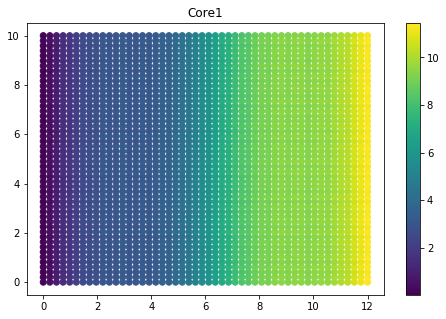

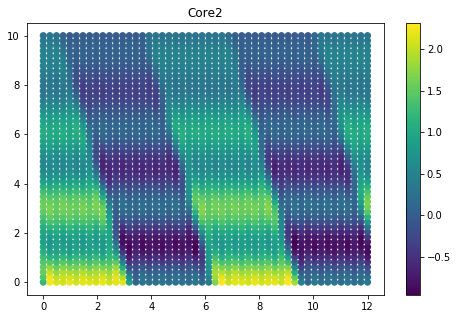

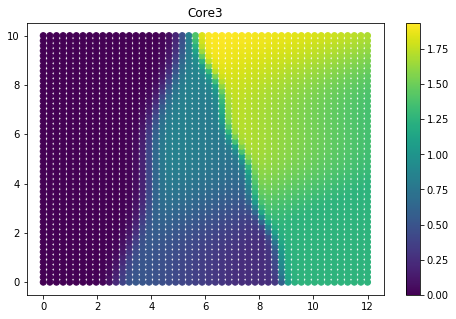

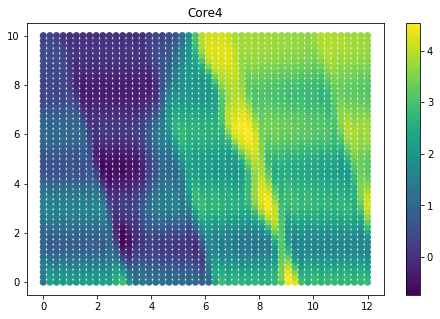

In [11]:
for cc in [1,2,3,4]:
    plt.figure(figsize=(8,5))
    scat = plt.scatter(grid_df.x1, grid_df.x2, c=grid_df[f'c{cc}'])
    plt.title(f'Core{cc}')
    plt.colorbar(scat)
    plt.show()
pass;

In [12]:
def core_f(x1,x2):
    return {f'c{cc}':coremodel[cc](x1, x2) for cc in [1,2,3,4]}

In [13]:
a = numpy.linspace(0,12,1000)

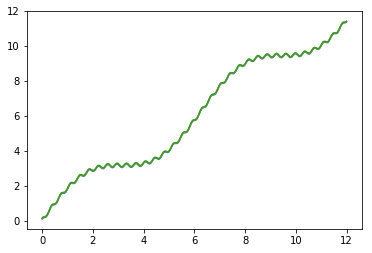

In [14]:
plt.plot(a, core1(a,0));
plt.plot(a, core1(a,1));
plt.plot(a, core1(a,3.1));

# EMAT Scope Def

In [15]:
scope_def="""---
scope:
    name: simplistic
inputs:
    x1:
        ptype: exogenous uncertainty
        default: 0
        min: 0.0
        max: 12.0
        dist:
            name: pert
            peak: 3
            gamma: 4
    x2:
        ptype: policy lever
        default: 1.0
        min: 0.0
        max: 10.0
outputs:
    c1:
        kind: minimize
    c2:
        kind: maximize
    c3:
        kind: maximize
    c4:
        kind: maximize

...
"""

In [16]:
s = emat.Scope(scope_file="/tmp/simple-scope.yaml", scope_def=scope_def)

In [17]:
db = emat.SQLiteDB()

[00:11.78] MainProcess/INFO: running script scope.sql
[00:11.79] MainProcess/INFO: running script exp_design.sql
[00:11.80] MainProcess/INFO: running script meta_model.sql


In [18]:
s.store_scope(db)

# EMAT Initial Design

In [19]:
from emat.experiment.experimental_design import design_experiments
design = design_experiments(s, n_samples_per_factor=10, sampler='lhs', db=db, random_seed=1)
design

x1        x2
experiment                    
1           1.924869  2.611062
2           5.978216  7.036682
3           2.867495  9.234619
4           3.773829  3.548086
5           1.590173  6.451685
6           5.220641  4.559745
7           2.193670  1.262400
8           6.463013  6.541812
9           2.958569  8.458431
10          1.269284  0.455224
11          5.052430  7.649465
12          0.495271  5.292195
13          9.012414  5.782956
14          7.754157  0.806969
15          3.734585  4.478268
16          5.484878  2.130489
17          3.197963  9.615508
18          4.434587  8.766724
19          4.340832  3.474969
20          2.354169  1.746530

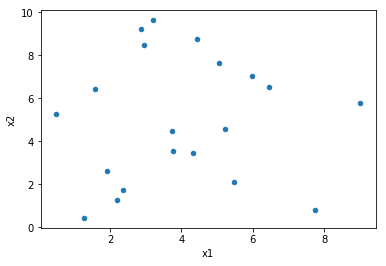

In [20]:
design.plot.scatter('x1','x2');

# EMAT Core Model

In [21]:
from emat.model.core_python import PythonCoreModel
m = PythonCoreModel(core_f, scope=s, db=db)

In [22]:
m

<emat.PythonCoreModel "EMAT", metamodel_id=None with 1 uncertainties, 1 levers, 4 measures>

In [23]:
from ema_workbench import SequentialEvaluator

In [24]:
with SequentialEvaluator(m) as eval_seq:
    lhs_results = m.run_experiments(design_name='lhs', evaluator=eval_seq)
lhs_results.head()

[00:12.10] MainProcess/INFO: performing 20 scenarios/policies * 1 model(s) = 20 experiments
[00:12.11] MainProcess/INFO: performing experiments sequentially
[00:12.11] MainProcess/INFO: 2 cases completed
[00:12.11] MainProcess/INFO: 4 cases completed
[00:12.12] MainProcess/INFO: 6 cases completed
[00:12.12] MainProcess/INFO: 8 cases completed
[00:12.12] MainProcess/INFO: 10 cases completed
[00:12.13] MainProcess/INFO: 12 cases completed
[00:12.13] MainProcess/INFO: 14 cases completed
[00:12.13] MainProcess/INFO: 16 cases completed
[00:12.14] MainProcess/INFO: 18 cases completed
[00:12.14] MainProcess/INFO: 20 cases completed
[00:12.14] MainProcess/INFO: experiments finished


x1        x2        c1        c2        c3        c4
experiment                                                            
1           1.924869  2.611062  2.936919  1.376146  0.000115  1.376376
2           5.978216  7.036682  5.693240  0.663295  0.813507  2.290309
3           2.867495  9.234619  3.195162  0.049877  0.000018  0.049914
4           3.773829  3.548086  3.277450  0.012885  0.284145  0.581174
5           1.590173  6.451685  2.625475  0.372122  0.000003  0.372129

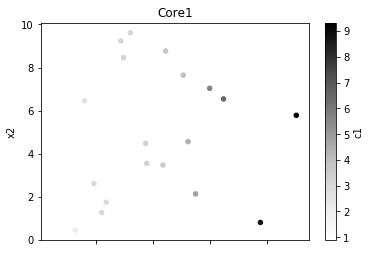

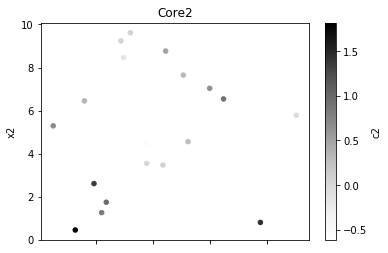

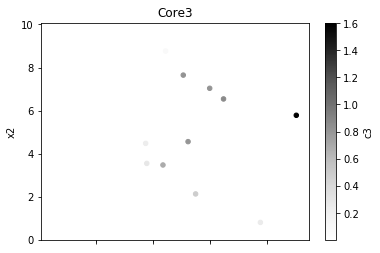

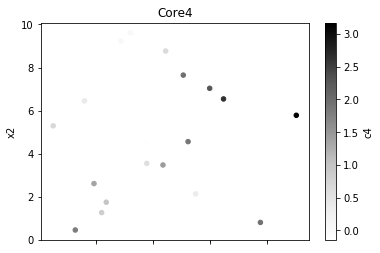

In [25]:
for cc in [1,2,3,4]:
    lhs_results.plot.scatter('x1','x2',c=f'c{cc}', title=f"Core{cc}");

## Initial MetaModel

In [26]:
mm = m.create_metamodel_from_design('lhs')
mm

<emat.PythonCoreModel "EMATMeta", metamodel_id=1 with 1 uncertainties, 1 levers, 4 measures>

In [27]:
cv_initial = mm.function.cross_val_scores()

In [28]:
cv_initial

c1    0.889948
c2    0.335878
c3    0.544100
c4    0.202418
dtype: float64

In [29]:
dict(1-cv_initial)

{'c1': 0.11005249845194243,
 'c2': 0.6641218983870107,
 'c3': 0.45589997242396874,
 'c4': 0.7975824417208075}

[00:26.36] MainProcess/INFO: performing 2500 scenarios/policies * 1 model(s) = 2500 experiments
[00:26.37] MainProcess/INFO: performing experiments sequentially
[00:27.55] MainProcess/INFO: 250 cases completed
[00:28.76] MainProcess/INFO: 500 cases completed
[00:29.93] MainProcess/INFO: 750 cases completed
[00:31.16] MainProcess/INFO: 1000 cases completed
[00:32.31] MainProcess/INFO: 1250 cases completed
[00:33.52] MainProcess/INFO: 1500 cases completed
[00:34.66] MainProcess/INFO: 1750 cases completed
[00:35.83] MainProcess/INFO: 2000 cases completed
[00:37.00] MainProcess/INFO: 2250 cases completed
[00:38.24] MainProcess/INFO: 2500 cases completed
[00:38.24] MainProcess/INFO: experiments finished


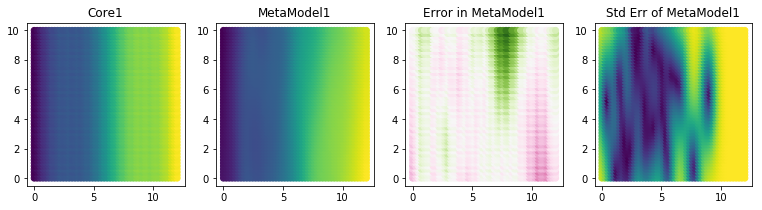

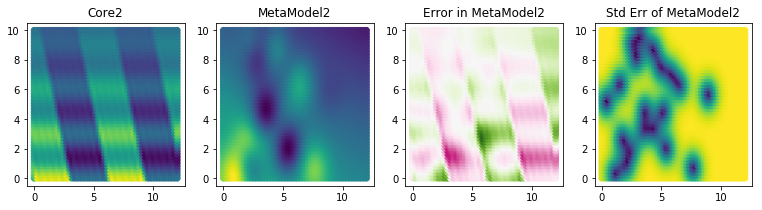

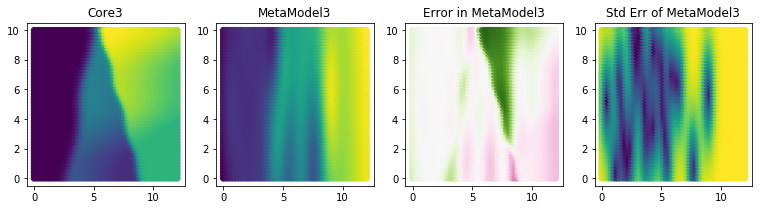

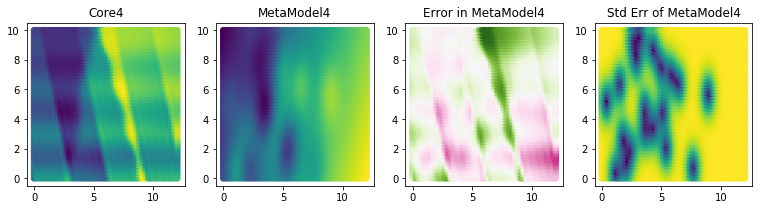

In [30]:
j = mm.run_experiments(grid_df[['x1','x2']], db=False)
j_stderr = mm.function.compute_std(grid_df[['x1','x2']])

for cc in [1,2,3,4]:
    fig, axs = plt.subplots(1,4, figsize=(13,3))
    axs[0].scatter(grid_df.x1, grid_df.x2, c=grid_df[f'c{cc}'])
    axs[0].set_title(f'Core{cc}')
    axs[1].scatter(j.x1, j.x2, c=j[f'c{cc}'])
    axs[1].set_title(f'MetaModel{cc}')
    diffs = grid_df[f'c{cc}']-j[f'c{cc}']
    maxdiff = numpy.fabs(diffs).max()
    axs[2].scatter(j.x1, j.x2, c=diffs, cmap='PiYG', vmin=-maxdiff, vmax=maxdiff)
    axs[2].set_title(f'Error in MetaModel{cc}')

    axs[3].scatter(j.x1, j.x2, c=j_stderr[f'c{cc}'])
    axs[3].set_title(f'Std Err of MetaModel{cc}')

    plt.show()

# Newman Batch System

In [31]:
from emat.experiment.experimental_design import minimum_weighted_distance, batch_pick_new_experiments  

In [32]:
n_augmentations = 4
batch_size = 8

In [33]:
newman_design_names = ['lhs',]
newman_mm = {-1: mm}
newman_cv = {-1: cv_initial}

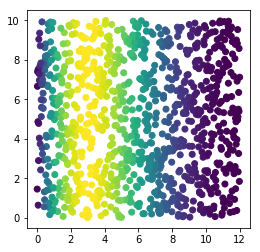

[00:54.68] MainProcess/INFO: computing density
[00:55.01] MainProcess/INFO: populating initial batch
[01:35.27] MainProcess/INFO: initial batch complete, checking for exchanges
[01:50.08] MainProcess/INFO: replacing 999 with 753
[02:04.88] MainProcess/INFO: replacing 181 with 826
[02:09.84] MainProcess/INFO: replacing 825 with 793
[02:14.77] MainProcess/INFO: 3 exchanges completed.
[02:34.69] MainProcess/INFO: replacing 586 with 704
[02:39.79] MainProcess/INFO: replacing 82 with 407
[02:44.94] MainProcess/INFO: replacing 826 with 624
[02:54.85] MainProcess/INFO: 3 exchanges completed.
[03:34.95] MainProcess/INFO: 0 exchanges completed.
[03:34.96] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[03:34.97] MainProcess/INFO: performing experiments sequentially
[03:34.97] MainProcess/INFO: 1 cases completed
[03:34.97] MainProcess/INFO: 2 cases completed
[03:34.98] MainProcess/INFO: 3 cases completed
[03:34.98] MainProcess/INFO: 4 cases completed
[03:34.98] Ma

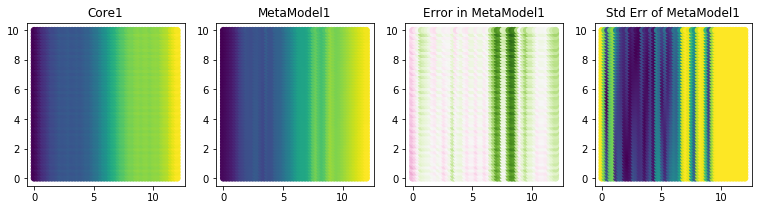

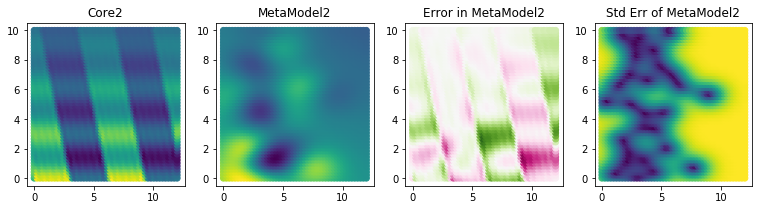

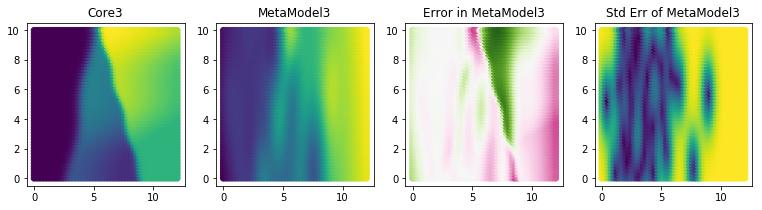

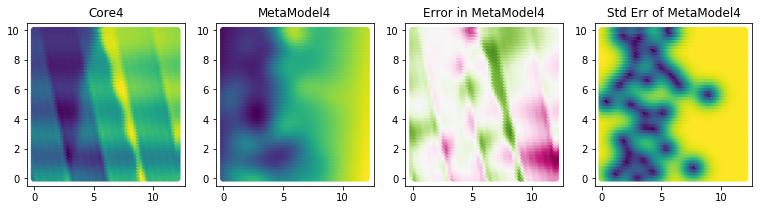

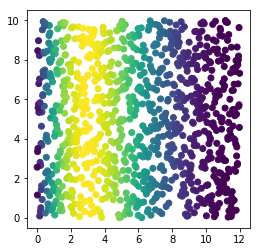

[04:17.62] MainProcess/INFO: computing density
[04:18.17] MainProcess/INFO: populating initial batch
[05:00.04] MainProcess/INFO: initial batch complete, checking for exchanges
[05:15.05] MainProcess/INFO: replacing 71 with 142
[05:20.02] MainProcess/INFO: replacing 592 with 673
[05:26.05] MainProcess/INFO: replacing 982 with 282
[05:42.71] MainProcess/INFO: 3 exchanges completed.
[06:25.08] MainProcess/INFO: 0 exchanges completed.
[06:25.10] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[06:25.11] MainProcess/INFO: performing experiments sequentially
[06:25.11] MainProcess/INFO: 1 cases completed
[06:25.12] MainProcess/INFO: 2 cases completed
[06:25.12] MainProcess/INFO: 3 cases completed
[06:25.13] MainProcess/INFO: 4 cases completed
[06:25.13] MainProcess/INFO: 5 cases completed
[06:25.13] MainProcess/INFO: 6 cases completed
[06:25.14] MainProcess/INFO: 7 cases completed
[06:25.14] MainProcess/INFO: 8 cases completed
[06:25.14] MainProcess/INFO: expe

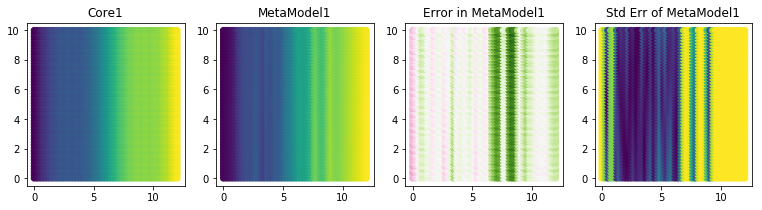

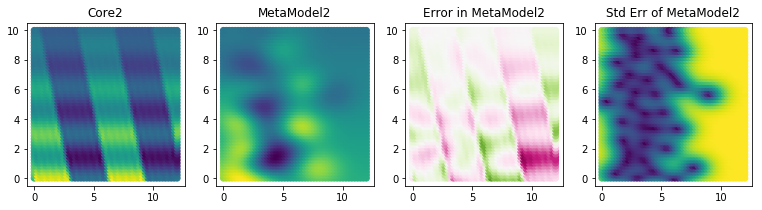

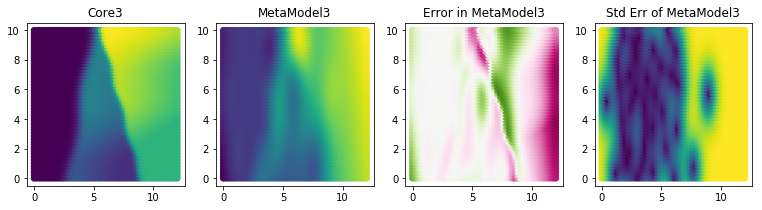

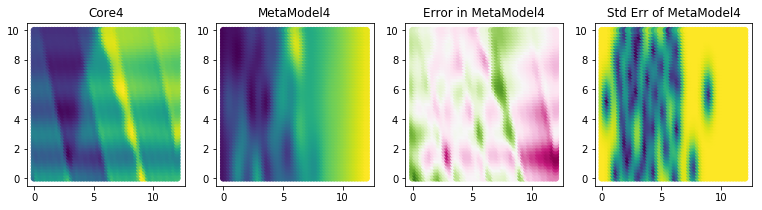

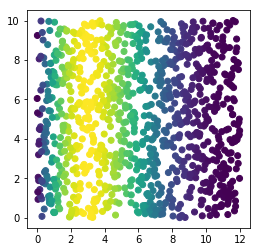

[07:12.77] MainProcess/INFO: computing density
[07:13.12] MainProcess/INFO: populating initial batch
[07:54.93] MainProcess/INFO: initial batch complete, checking for exchanges
[08:25.33] MainProcess/INFO: replacing 214 with 692
[08:41.63] MainProcess/INFO: 1 exchanges completed.
[09:38.06] MainProcess/INFO: 0 exchanges completed.
[09:38.07] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[09:38.08] MainProcess/INFO: performing experiments sequentially
[09:38.09] MainProcess/INFO: 1 cases completed
[09:38.09] MainProcess/INFO: 2 cases completed
[09:38.10] MainProcess/INFO: 3 cases completed
[09:38.10] MainProcess/INFO: 4 cases completed
[09:38.10] MainProcess/INFO: 5 cases completed
[09:38.11] MainProcess/INFO: 6 cases completed
[09:38.12] MainProcess/INFO: 7 cases completed
[09:38.12] MainProcess/INFO: 8 cases completed
[09:38.13] MainProcess/INFO: experiments finished
[09:54.72] MainProcess/INFO: performing 2500 scenarios/policies * 1 model(s) = 2500 ex

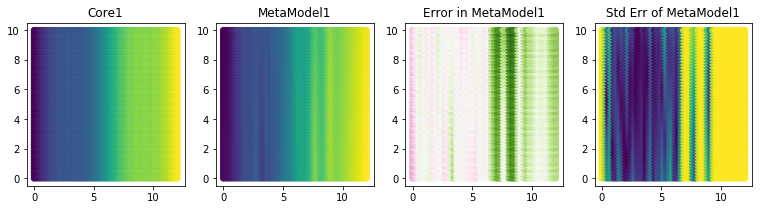

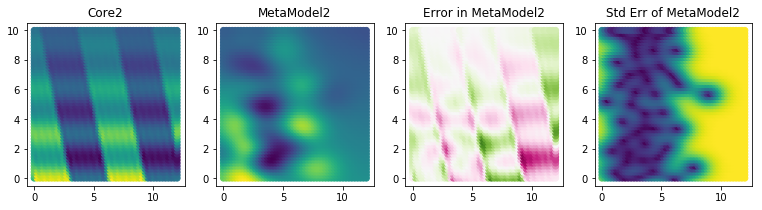

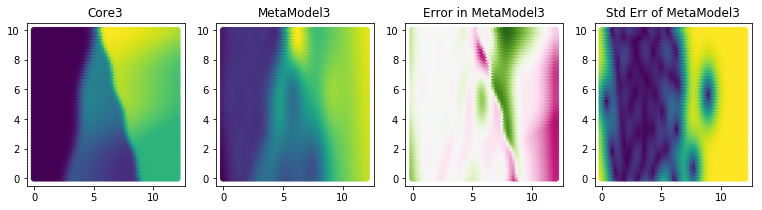

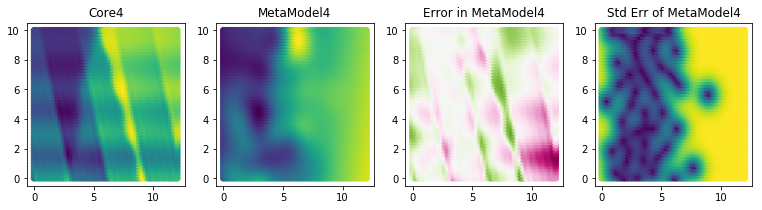

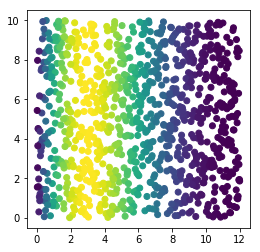

[10:25.58] MainProcess/INFO: computing density
[10:25.91] MainProcess/INFO: populating initial batch
[11:06.20] MainProcess/INFO: initial batch complete, checking for exchanges
[11:36.49] MainProcess/INFO: replacing 945 with 959
[11:41.50] MainProcess/INFO: replacing 668 with 571
[11:46.87] MainProcess/INFO: 2 exchanges completed.
[12:35.47] MainProcess/INFO: 0 exchanges completed.
[12:35.48] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[12:35.49] MainProcess/INFO: performing experiments sequentially
[12:35.49] MainProcess/INFO: 1 cases completed
[12:35.49] MainProcess/INFO: 2 cases completed
[12:35.50] MainProcess/INFO: 3 cases completed
[12:35.50] MainProcess/INFO: 4 cases completed
[12:35.50] MainProcess/INFO: 5 cases completed
[12:35.51] MainProcess/INFO: 6 cases completed
[12:35.52] MainProcess/INFO: 7 cases completed
[12:35.52] MainProcess/INFO: 8 cases completed
[12:35.53] MainProcess/INFO: experiments finished
[12:53.32] MainProcess/INFO: perfo

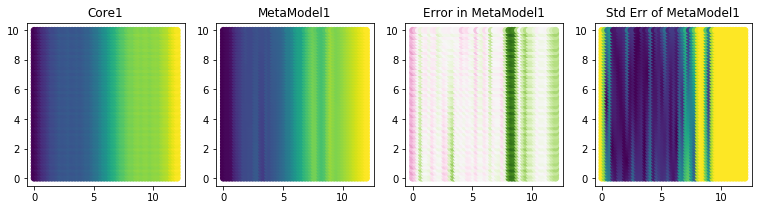

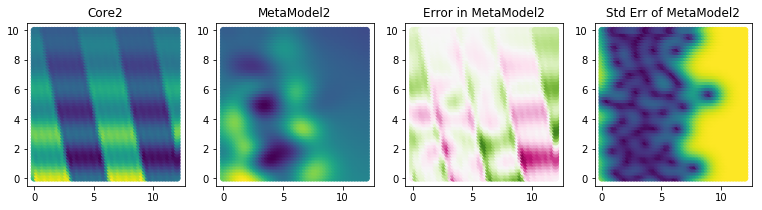

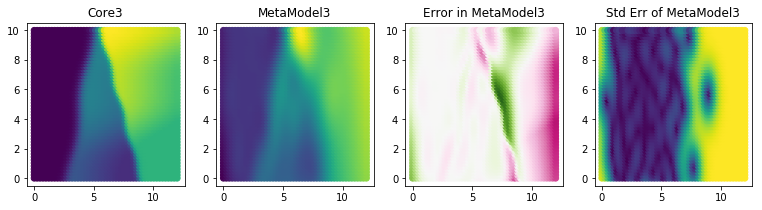

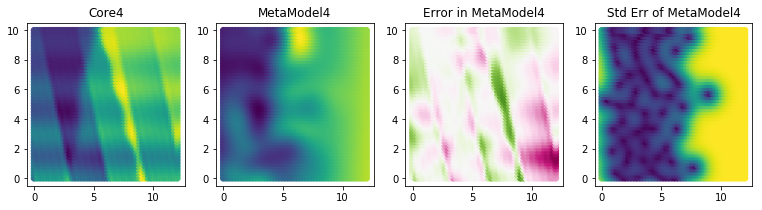

In [34]:
for i in range(n_augmentations):

    pool = design_experiments(s, n_samples=1000, sampler='ulhs', random_seed=118+i)
    pool_density = pool.apply(lambda x: s.get_density(x), axis=1)

    # Plot candidate density.
    fig, axs = plt.subplots(1,1, figsize=(4,4))
    axs.scatter(pool.x1, pool.x2, c=pool_density)
    plt.show() 
    plt.close(fig)
    
    poorness_of_fit = dict(1-newman_cv[i-1])
    
    # Pick new experiments from the candidate pool
    new_ex = newman_mm[i-1].function.heuristic_batch_pick_experiment(
        batch_size=batch_size,
        candidate_experiments=pool, 
        scope=s,
        poorness_of_fit=poorness_of_fit, 
        plot=False,
    )
    
    ## Conduct Picks
    new_ex.index = m.db.write_experiment_parameters(scope_name=s.name, design_name=f'newman_{i}', xl_df=new_ex)
    new_ex_results = m.run_experiments(design=new_ex)
    
    newman_design_names.append(f'newman_{i}')

    ## New Metamodel
    newman_mm[i] = m.create_metamodel_from_designs(newman_design_names)
    newman_cv[i] = newman_mm[i].function.cross_val_scores()
    
    j = newman_mm[i].run_experiments(grid_df[['x1','x2']], db=False)
    j_stderr = newman_mm[i].function.compute_std(grid_df[['x1','x2']])

    for cc in [1,2,3,4]:
        fig, axs = plt.subplots(1,4, figsize=(13,3))
        axs[0].scatter(grid_df.x1, grid_df.x2, c=grid_df[f'c{cc}'])
        axs[0].set_title(f'Core{cc}')
        axs[1].scatter(j.x1, j.x2, c=j[f'c{cc}'])
        axs[1].set_title(f'MetaModel{cc}')
        diffs = grid_df[f'c{cc}']-j[f'c{cc}']
        maxdiff = numpy.fabs(diffs).max()
        axs[2].scatter(j.x1, j.x2, c=diffs, cmap='PiYG', vmin=-maxdiff, vmax=maxdiff)
        axs[2].set_title(f'Error in MetaModel{cc}')

        axs[3].scatter(j.x1, j.x2, c=j_stderr[f'c{cc}'])
        axs[3].set_title(f'Std Err of MetaModel{cc}')

        plt.show()
        
pass;

In [35]:
############## #####

In [36]:
future_exper = design_experiments(s, n_samples=1000, sampler='lhs', random_seed=124)

In [37]:
future_exper.head()

x1        x2
0  1.192078  2.212413
1  5.785421  2.942410
2  6.607914  5.476999
3  3.878492  5.565825
4  5.828658  0.481445

In [38]:
# future_exper.apply(
#         lambda x: pandas.Series(aug_mm[aug-1].function.compute_std(**x)), 
#         axis=1,
#     )

# Loeppky Batch System

In [39]:
aug_design = {}
aug_results = {}
aug_mm = {-1: mm}
aug_cv = {-1: cv_initial}
aug_names = ['lhs',]

[13:32.21] MainProcess/INFO: Selecting 3211
[13:32.29] MainProcess/INFO: Selecting 3106
[13:32.40] MainProcess/INFO: Selecting 2321
[13:32.49] MainProcess/INFO: Selecting 4577
[13:32.57] MainProcess/INFO: Selecting 4743
[13:32.67] MainProcess/INFO: Selecting 4448
[13:32.77] MainProcess/INFO: Selecting 3764
[13:32.86] MainProcess/INFO: Selecting 3747
[13:33.03] MainProcess/INFO: Replacing 3211 with 4125
[13:33.43] MainProcess/INFO: Replacing 4448 with 528
[13:33.52] MainProcess/INFO: Replacing 3764 with 1379
[13:33.62] MainProcess/INFO: 3 Fedorov Exchanges completed.
[13:34.07] MainProcess/INFO: Replacing 528 with 4448
[13:34.16] MainProcess/INFO: Replacing 1379 with 1355
[13:34.25] MainProcess/INFO: 2 Fedorov Exchanges completed.
[13:35.89] MainProcess/INFO: 0 Fedorov Exchanges completed.
[13:35.91] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[13:35.92] MainProcess/INFO: performing experiments sequentially
[13:35.92] MainProcess/INFO: 1 cases complete

c1    0.992402
c2    0.277301
c3    0.714492
c4    0.596300
dtype: float64


[14:20.89] MainProcess/INFO: performing 2500 scenarios/policies * 1 model(s) = 2500 experiments
[14:20.90] MainProcess/INFO: performing experiments sequentially
[14:22.60] MainProcess/INFO: 250 cases completed
[14:23.97] MainProcess/INFO: 500 cases completed
[14:25.32] MainProcess/INFO: 750 cases completed
[14:26.77] MainProcess/INFO: 1000 cases completed
[14:28.14] MainProcess/INFO: 1250 cases completed
[14:29.48] MainProcess/INFO: 1500 cases completed
[14:30.74] MainProcess/INFO: 1750 cases completed
[14:32.26] MainProcess/INFO: 2000 cases completed
[14:33.46] MainProcess/INFO: 2250 cases completed
[14:34.66] MainProcess/INFO: 2500 cases completed
[14:34.66] MainProcess/INFO: experiments finished


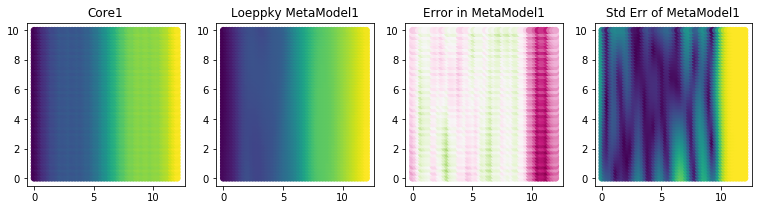

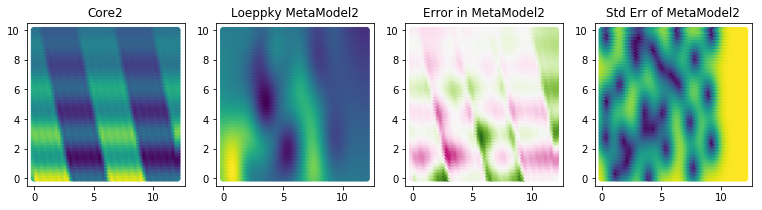

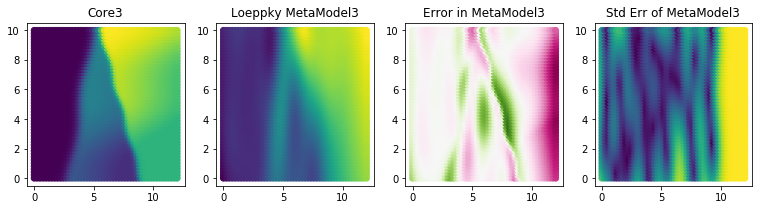

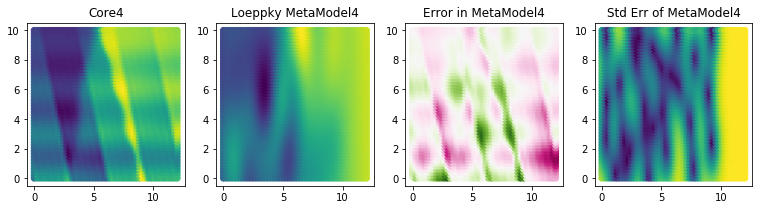

------- ~~~ --------


[14:55.99] MainProcess/INFO: Selecting 2395
[14:56.09] MainProcess/INFO: Selecting 4136
[14:56.18] MainProcess/INFO: Selecting 2645
[14:56.26] MainProcess/INFO: Selecting 378
[14:56.33] MainProcess/INFO: Selecting 4760
[14:56.42] MainProcess/INFO: Selecting 120
[14:56.50] MainProcess/INFO: Selecting 784
[14:56.59] MainProcess/INFO: Selecting 4918
[14:57.17] MainProcess/INFO: 0 Fedorov Exchanges completed.
[14:57.18] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[14:57.19] MainProcess/INFO: performing experiments sequentially
[14:57.19] MainProcess/INFO: 1 cases completed
[14:57.20] MainProcess/INFO: 2 cases completed
[14:57.21] MainProcess/INFO: 3 cases completed
[14:57.21] MainProcess/INFO: 4 cases completed
[14:57.21] MainProcess/INFO: 5 cases completed
[14:57.22] MainProcess/INFO: 6 cases completed
[14:57.22] MainProcess/INFO: 7 cases completed
[14:57.23] MainProcess/INFO: 8 cases completed
[14:57.23] MainProcess/INFO: experiments finished


c1    0.992987
c2    0.492590
c3    0.816755
c4    0.592024
dtype: float64


[15:40.73] MainProcess/INFO: performing 2500 scenarios/policies * 1 model(s) = 2500 experiments
[15:40.74] MainProcess/INFO: performing experiments sequentially
[15:42.05] MainProcess/INFO: 250 cases completed
[15:43.25] MainProcess/INFO: 500 cases completed
[15:44.47] MainProcess/INFO: 750 cases completed
[15:45.78] MainProcess/INFO: 1000 cases completed
[15:46.98] MainProcess/INFO: 1250 cases completed
[15:48.20] MainProcess/INFO: 1500 cases completed
[15:49.58] MainProcess/INFO: 1750 cases completed
[15:50.82] MainProcess/INFO: 2000 cases completed
[15:52.19] MainProcess/INFO: 2250 cases completed
[15:53.46] MainProcess/INFO: 2500 cases completed
[15:53.46] MainProcess/INFO: experiments finished


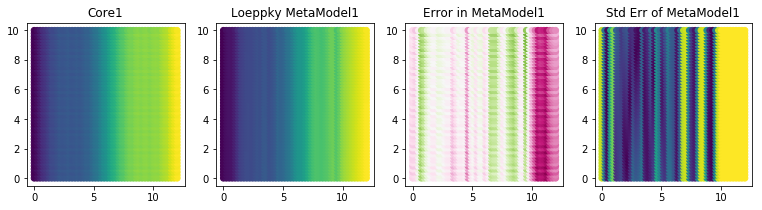

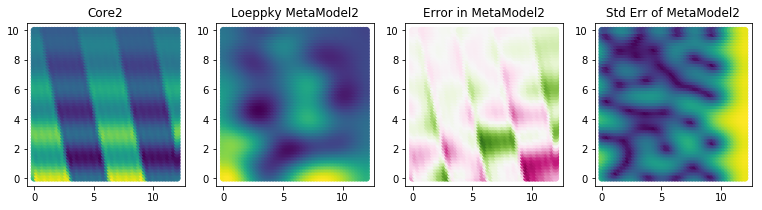

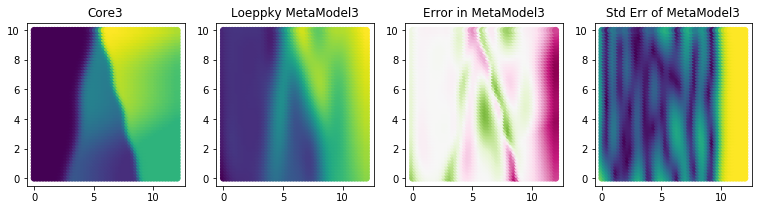

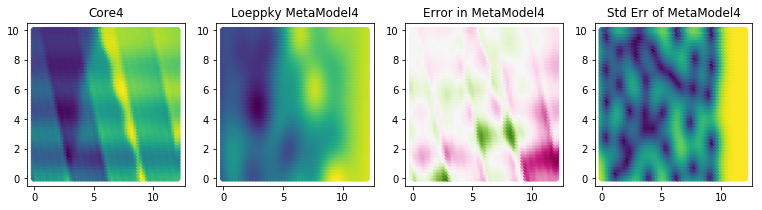

------- ~~~ --------


[16:19.32] MainProcess/INFO: Selecting 4228
[16:19.41] MainProcess/INFO: Selecting 4389
[16:19.49] MainProcess/INFO: Selecting 945
[16:19.56] MainProcess/INFO: Selecting 1223
[16:19.65] MainProcess/INFO: Selecting 214
[16:19.72] MainProcess/INFO: Selecting 674
[16:19.81] MainProcess/INFO: Selecting 303
[16:19.90] MainProcess/INFO: Selecting 3014
[16:20.46] MainProcess/INFO: 0 Fedorov Exchanges completed.
[16:20.47] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[16:20.48] MainProcess/INFO: performing experiments sequentially
[16:20.48] MainProcess/INFO: 1 cases completed
[16:20.49] MainProcess/INFO: 2 cases completed
[16:20.49] MainProcess/INFO: 3 cases completed
[16:20.49] MainProcess/INFO: 4 cases completed
[16:20.50] MainProcess/INFO: 5 cases completed
[16:20.50] MainProcess/INFO: 6 cases completed
[16:20.50] MainProcess/INFO: 7 cases completed
[16:20.50] MainProcess/INFO: 8 cases completed
[16:20.51] MainProcess/INFO: experiments finished


c1    0.992211
c2    0.244182
c3    0.914305
c4    0.719499
dtype: float64


[17:13.34] MainProcess/INFO: performing 2500 scenarios/policies * 1 model(s) = 2500 experiments
[17:13.35] MainProcess/INFO: performing experiments sequentially
[17:14.59] MainProcess/INFO: 250 cases completed
[17:16.20] MainProcess/INFO: 500 cases completed
[17:17.82] MainProcess/INFO: 750 cases completed
[17:19.24] MainProcess/INFO: 1000 cases completed
[17:20.87] MainProcess/INFO: 1250 cases completed
[17:22.46] MainProcess/INFO: 1500 cases completed
[17:23.95] MainProcess/INFO: 1750 cases completed
[17:25.63] MainProcess/INFO: 2000 cases completed
[17:27.39] MainProcess/INFO: 2250 cases completed
[17:29.18] MainProcess/INFO: 2500 cases completed
[17:29.19] MainProcess/INFO: experiments finished


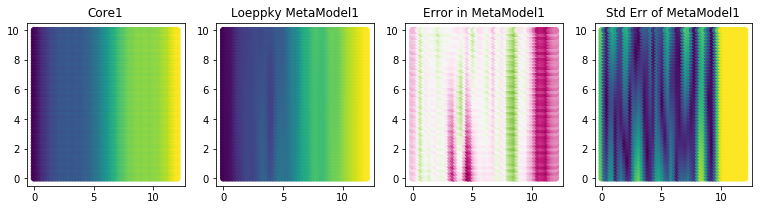

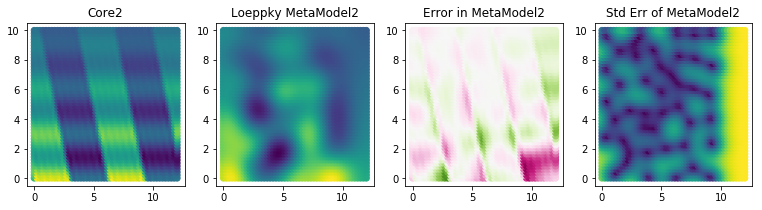

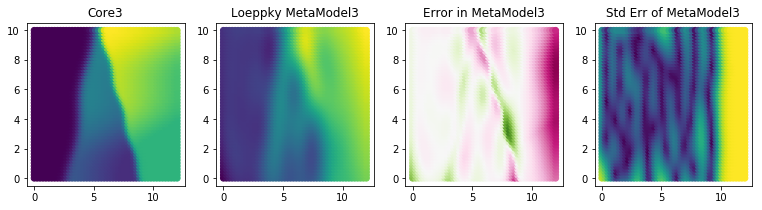

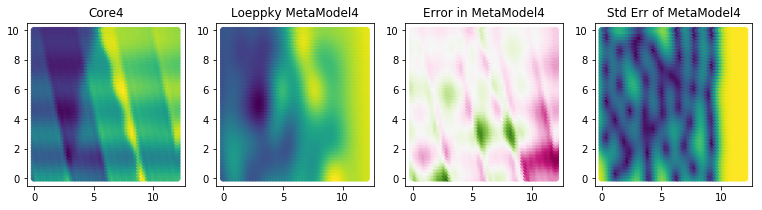

------- ~~~ --------


[17:54.23] MainProcess/INFO: Selecting 697
[17:54.32] MainProcess/INFO: Selecting 2329
[17:54.39] MainProcess/INFO: Selecting 3523
[17:54.48] MainProcess/INFO: Selecting 903
[17:54.56] MainProcess/INFO: Selecting 2410
[17:54.64] MainProcess/INFO: Selecting 532
[17:54.74] MainProcess/INFO: Selecting 3837
[17:54.83] MainProcess/INFO: Selecting 1232
[17:55.42] MainProcess/INFO: 0 Fedorov Exchanges completed.
[17:55.43] MainProcess/INFO: performing 8 scenarios/policies * 1 model(s) = 8 experiments
[17:55.44] MainProcess/INFO: performing experiments sequentially
[17:55.44] MainProcess/INFO: 1 cases completed
[17:55.44] MainProcess/INFO: 2 cases completed
[17:55.44] MainProcess/INFO: 3 cases completed
[17:55.45] MainProcess/INFO: 4 cases completed
[17:55.45] MainProcess/INFO: 5 cases completed
[17:55.45] MainProcess/INFO: 6 cases completed
[17:55.46] MainProcess/INFO: 7 cases completed
[17:55.46] MainProcess/INFO: 8 cases completed
[17:55.46] MainProcess/INFO: experiments finished


c1    0.991655
c2    0.339682
c3    0.946504
c4    0.660389
dtype: float64


[18:49.09] MainProcess/INFO: performing 2500 scenarios/policies * 1 model(s) = 2500 experiments
[18:49.10] MainProcess/INFO: performing experiments sequentially
[18:50.41] MainProcess/INFO: 250 cases completed
[18:51.86] MainProcess/INFO: 500 cases completed
[18:53.45] MainProcess/INFO: 750 cases completed
[18:54.74] MainProcess/INFO: 1000 cases completed
[18:56.45] MainProcess/INFO: 1250 cases completed
[18:58.01] MainProcess/INFO: 1500 cases completed
[18:59.35] MainProcess/INFO: 1750 cases completed
[19:00.93] MainProcess/INFO: 2000 cases completed
[19:02.33] MainProcess/INFO: 2250 cases completed
[19:03.90] MainProcess/INFO: 2500 cases completed
[19:03.91] MainProcess/INFO: experiments finished


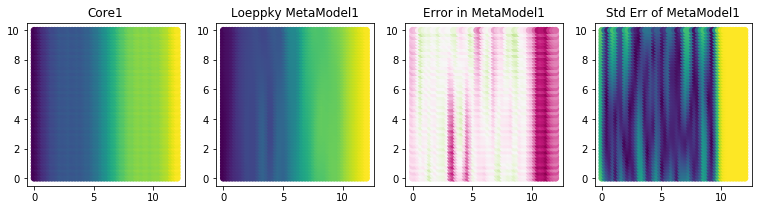

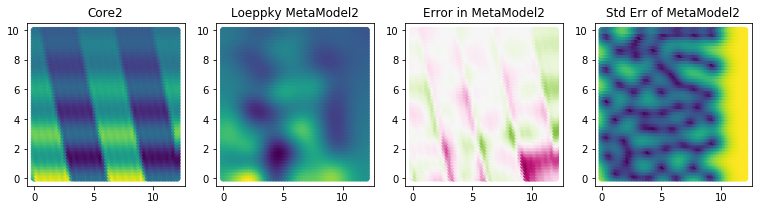

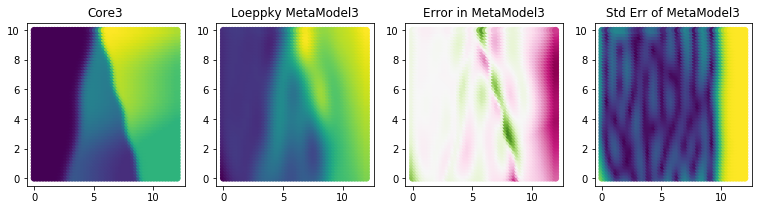

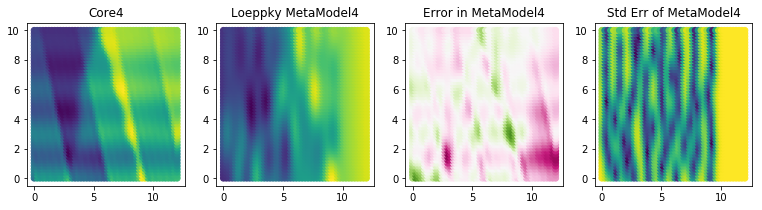

------- ~~~ --------


In [40]:
for aug in range(n_augmentations):
    design_pool = design_experiments(s, n_samples=5000, sampler='ulhs98', random_seed=42+aug)
    
    future_exper_std = future_exper.apply(
        lambda x: pandas.Series(aug_mm[aug-1].function.compute_std(**x)), 
        axis=1,
    )
    
    aug_design[aug] = aug_mm[aug-1].function.pick_new_experiments(
            design_pool,
            batch_size=batch_size,
            output_focus=dict(1-aug_cv[aug-1]),
            scope=s,
            db=db,
            design_name=f'aug_{aug}',
#             debug=('x1','x2'),
#             future_experiments=future_exper,
#             future_experiments_std=future_exper_std,
    )
    with SequentialEvaluator(m) as eval_seq:
        aug_results[aug] = m.run_experiments(design_name=f'aug_{aug}', evaluator=eval_seq)
    aug_names.append(f'aug_{aug}')
    aug_mm[aug] = m.create_metamodel_from_designs(aug_names)
    aug_cv[aug] = aug_mm[aug].function.cross_val_scores()
    print(aug_cv[aug])
    
    # Show STDERR from Metamodels
    design_pool_std = design_pool[['x1','x2']].apply(
        lambda x: pandas.Series(aug_mm[aug-1].function.compute_std(**x)), 
        axis=1,
    )
    
    j = aug_mm[aug].run_experiments(grid_df[['x1','x2']], db=False)
    j_stderr = aug_mm[aug].function.compute_std(grid_df[['x1','x2']])

    
    for cc in [1,2,3,4]:
        fig, axs = plt.subplots(1,4, figsize=(13,3))
        axs[0].scatter(grid_df.x1, grid_df.x2, c=grid_df[f'c{cc}'])
        axs[0].set_title(f'Core{cc}')
        axs[1].scatter(j.x1, j.x2, c=j[f'c{cc}'])
        axs[1].set_title(f'Loeppky MetaModel{cc}')
        diffs = grid_df[f'c{cc}']-j[f'c{cc}']
        maxdiff = numpy.fabs(diffs).max()
        axs[2].scatter(j.x1, j.x2, c=diffs, cmap='PiYG', vmin=-maxdiff, vmax=maxdiff)
        axs[2].set_title(f'Error in MetaModel{cc}')

        axs[3].scatter(j.x1, j.x2, c=j_stderr[f'c{cc}'])
        axs[3].set_title(f'Std Err of MetaModel{cc}')

        plt.show()


#     for cc in [1,2,3,4]:
#         print(f"------- Figure {cc} --------")

#         plt.clf()
#         #plt.figure(figsize=(12,7))
#         scat = plt.scatter(design_pool.x1, design_pool.x2, c=design_pool[f'std_{cc}'])
#         plt.colorbar(scat)
#         plt.scatter(aug_design[aug].x1, aug_design[aug].x2, color="red", marker='x')
#         plt.title(f"Metamodel Std Err for Core{cc}");
#         plt.show()
    
    print("------- ~~~ --------")


In [41]:
raise RuntimeError

RuntimeError: 

In [ ]:
pandas.DataFrame(newman_cv)

In [ ]:
pandas.DataFrame(aug_cv)

In [ ]:
aug_mm[-1].function.regression.X_train_.shape

In [ ]:
aug_mm[0].function.regression.X_train_.shape

In [ ]:
ax = design.plot.scatter('x1','x2')
ax = aug_design[0].plot.scatter('x1','x2', ax=ax, c='#A00000', s=30)
ax = aug_design[1].plot.scatter('x1','x2', ax=ax, c='#FF0000', s=30)
ax = aug_design[0].plot.scatter('x1','x2', ax=ax, c='#00FF00', s=30)



In [ ]:
plt.plot(design.x1, design.x2, 'ko')
plt.plot(aug_design[0].x1, aug_design[0].x2, "ro", marker=r'$①$', markersize=22)
plt.plot(aug_design[1].x1, aug_design[1].x2, "bo", marker=r'$②$', markersize=22)
plt.plot(aug_design[2].x1, aug_design[2].x2, "go", marker=r'$③$', markersize=22)
plt.plot(aug_design[3].x1, aug_design[3].x2, "yo", marker=r'$④$', markersize=22)

In [ ]:
# TEST

In [ ]:
testdesign = design_experiments(s, n_samples=10000, sampler='lhs', random_seed=123)

In [ ]:
testresults_core = m.run_experiments(design=testdesign, db=False)
testresults_core.head()

In [ ]:
plt.figure(figsize=(12,7))
scat = plt.scatter(testresults_core.x1, testresults_core.x2, c=testresults_core.Bb)
plt.colorbar(scat)
plt.title("Core Model Outcomes for Bb");

In [ ]:
plt.figure(figsize=(12,7))
scat = plt.scatter(testresults_core.x1, testresults_core.x2, c=testresults_core.Aa)
plt.colorbar(scat)

In [ ]:
testresults_3 = aug_mm[3].run_experiments(design=testdesign, db=False)
testresults_3.head()

In [ ]:
plt.figure(figsize=(12,7))
scat = plt.scatter(testresults_3.x1, testresults_3.x2, c=testresults_3.Bb)
plt.colorbar(scat)
plt.title("Augmented MetaModel Predictions for Bb");

In [ ]:
testresults_3['BbZ'] = testresults_core.Bb

In [ ]:
aug_mm[3].function(x1=1.312643, x2=9.547349)

In [ ]:
m.function(x1=1.312643, x2=9.547349)

In [ ]:
plt.figure(figsize=(12,7))

scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=numpy.absolute(testresults_3['Bb'] - testresults_3['BbZ']), 
    cmap='viridis_r',
)
plt.colorbar(scat)

plt.scatter(
    aug_mm[3].function.input_sample.x1, 
    aug_mm[3].function.input_sample.x2, 
    #c=aug_mm[3].function.output_sample.Bb,
    color='red',
)
plt.title("Absolute Value of Augmented MetaModel Error for Bb");

In [ ]:
plt.figure(figsize=(12,7))

scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=(testresults_3['Bb'] - testresults_3['BbZ']), 
    cmap='PiYG',
)
plt.colorbar(scat)

plt.scatter(
    aug_mm[3].function.input_sample.x1, 
    aug_mm[3].function.input_sample.x2, 
    #c=aug_mm[3].function.output_sample.Bb,
    color='red',
)
plt.title("Absolute Value of Augmented MetaModel Error for Bb");

In [ ]:
testresults_3[['std_Aa', 'std_Bb']] = testresults_3[['x1','x2']].apply(
    lambda x: pandas.Series(aug_mm[3].function.compute_std(**x)), 
    axis=1,
)

In [ ]:
testresults_3['std_Bb'] = testresults_3[['x1','x2']].apply(
    lambda x: aug_mm[3].function.compute_std(**x)['Bb'], 
    axis=1,
)

In [ ]:
zzz= testresults_3[['x1','x2']].head().copy()

In [ ]:
zzz.apply(
    lambda x: pandas.Series(aug_mm[3].function.compute_std(**x)), 
    axis=1,
)

In [ ]:
zzz

In [ ]:
plt.figure(figsize=(12,7))

scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=testresults_3['std_Bb'], 
    cmap='viridis',
)
plt.colorbar(scat)

plt.scatter(
    aug_mm[3].function.input_sample.x1, 
    aug_mm[3].function.input_sample.x2, 
    #c=aug_mm[3].function.output_sample.Bb,
    color='red',
)

plt.title("Computed GPR Std Dev from Augmented MetaModel for Bb");

In [ ]:
plt.figure(figsize=(12,7))

scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=testresults_3['std_Aa'], 
    cmap='viridis',
)
plt.colorbar(scat)

plt.scatter(
    aug_mm[3].function.input_sample.x1, 
    aug_mm[3].function.input_sample.x2, 
    color='red',
)


plt.title("Computed GPR Std Dev from Augmented MetaModel for Aa");

In [ ]:
testresults_3['std_Aa'].min()

In [ ]:
ma = aug_mm[3]
# ma = m.create_metamodel_from_designs(design_names)

In [ ]:
X = numpy.asarray([5.97821617,7.03668209]).reshape(1, -1)

In [ ]:
ma.function.regression.step1.estimators_[1].kernel_

In [ ]:
gaussian = ma.function.regression.step1.estimators_[1].predict(X) * ma.function.regression.standardize_Y[None, 1]

In [ ]:
detrend = ma.function.regression.detrend_predict(X)['Bb'].values
detrend, gaussian, detrend+gaussian

In [ ]:
ma.function(x1=X[0,0],x2=X[0,1])

In [ ]:
ma2 = ma.function.regression.step1.estimators_[1]

In [ ]:
import sklearn
ma3 = sklearn.base.clone(ma.function.regression.step1.estimators_[1], safe=True)

In [ ]:
from copy import deepcopy
ma3 = deepcopy(ma.function.regression.step1.estimators_[1])

In [ ]:
ma2_X = ma2.X_train_.copy()
ma2_y = ma2.y_train_.copy()
ma2_a = ma2.alpha_.copy()

In [ ]:
# if 1:
#     ma2.X_train_ = ma2_X
#     ma2.y_train_ = ma2_y 
#     ma2.alpha_   = ma2_a 

In [ ]:
ma3.X_train_ = numpy.delete(ma3.X_train_, 1, 0)

ma3.y_train_ = numpy.delete(ma3.y_train_, 1, 0)

ma3.alpha_ =  numpy.delete(ma3.alpha_, 1, 0)

In [ ]:
ma2.alpha_

In [ ]:
ma3.alpha_

In [ ]:
ma3.predict(X) * ma.function.regression.standardize_Y[None, 1]

In [ ]:
ma.function.regression.step1.estimators_[1].predict(X) * ma.function.regression.standardize_Y[None, 1]

In [ ]:

ma.function.regression.predict(X)

In [ ]:
ma.function.regression.detrend_predict(X)

In [ ]:
ma.function.regression.residual_predict(X)

In [ ]:
pandas.Series({'x1':7,'x2':7})

In [ ]:
ma.function.preprocess_raw_input(pandas.Series({'x1':7,'x2':7}))

In [ ]:
ma.function.input_sample

In [ ]:

def leave_one_out_prediction(metamodel):
    
    from copy import deepcopy
    
    n_rows = len(metamodel.input_sample)
    result = {}
    
    for i in range(n_rows):
        meat = deepcopy(metamodel)
        for e in meat.regression.step1.estimators_:
            pass
            e.X_train_ = numpy.delete(e.X_train_, i, 0)
            e.y_train_ = numpy.delete(e.y_train_, i, 0)
            e.alpha_ =  numpy.delete(e.alpha_, i, 0)
        result[i] = meat(**metamodel.input_sample.iloc[i])
    return result

In [ ]:
leave_one_out_prediction(ma.function)

In [ ]:
cv0_predict = ma.function.cross_val_predicts(cv=0)

In [ ]:
cv0_predict

In [ ]:
cv0_error = ma.function.output_sample - cv0_predict

In [ ]:
scat = plt.scatter(
    ma.function.input_sample.x1, 
    ma.function.input_sample.x2, 
    c=cv0_error.Aa,
    cmap='PiYG'
)
plt.colorbar(scat)

In [ ]:
scat = plt.scatter(
    testresults_3.x1, 
    testresults_3.x2, 
    c=testresults_3['std_Bb'], 
    cmap='Greys',
)
plt.colorbar(scat)

scat = plt.scatter(
    ma.function.input_sample.x1, 
    ma.function.input_sample.x2, 
    500*cv0_error.Bb**2,
    color='red'
)
